In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

C:\Users\zx\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def show(img, title=None):
    plt.figure(figsize=(8, 8))
    plt.grid(False)
    plt.axis('off')
    if len(img.shape) > 3:
        img = img.squeeze(0)
    title = title if title else img.shape
    plt.title(title)
    plt.imshow(img)
    
def load_image(path_to_img, img_shape=(224, 224)):
    img = Image.open(path_to_img)
    img = img.resize((256, 256),Image.ANTIALIAS)
    print(img.size)
    max_dim = 512
    shape = np.array(img.size)
    long_dim = max(shape)
    scale = max_dim / float(long_dim)
    new_shape = (shape * scale).astype(np.int32)
    img = np.array(img.resize(new_shape))
    img = np.expand_dims(img, 0)
    return img

(256, 256)
0 255


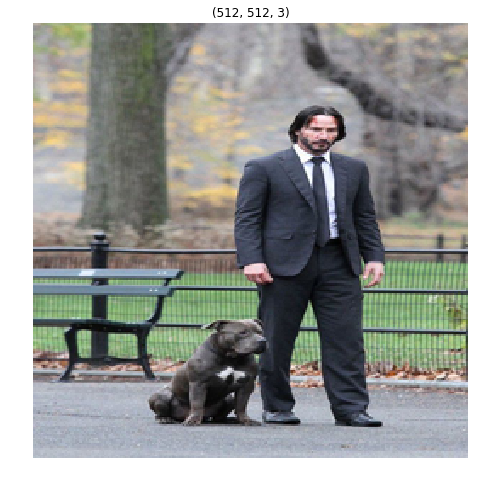

In [3]:
img = load_image("images/john-wick-2-dog.jpg")
print(img.min(), img.max())
show(img)

In [4]:
img = tf.keras.applications.vgg19.preprocess_input(img.astype(float))
img.shape

(1, 512, 512, 3)

# server mrthod

In [5]:
import requests
import json
import base64
headers = {"content-type": "application/json"}
json_response = requests.get('http://localhost:8501/v1/models/style_transfer/metadata', headers=headers)
result = json.loads(json_response.text)
result

{'model_spec': {'name': 'style_transfer',
  'signature_name': '',
  'version': '1'},
 'metadata': {'signature_def': {'signature_def': {'style_transfer': {'inputs': {'input_s': {'dtype': 'DT_FLOAT',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '256', 'name': ''},
         {'size': '256', 'name': ''},
         {'size': '3', 'name': ''}],
        'unknown_rank': False},
       'name': 'input_s:0'},
      'input_c': {'dtype': 'DT_FLOAT',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '256', 'name': ''},
         {'size': '256', 'name': ''},
         {'size': '3', 'name': ''}],
        'unknown_rank': False},
       'name': 'input_c:0'}},
     'outputs': {'clip_by_value:0': {'dtype': 'DT_FLOAT',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '256', 'name': ''},
         {'size': '256', 'name': ''},
         {'size': '3', 'name': ''}],
        'unknown_rank': False},
       'name': 'clip_by_value:0

In [6]:
from io import BytesIO
buff = BytesIO(img.tobytes())
# new_image_string = base64.b64encode(buff.getvalue())
data = json.dumps(
    {
        "signature_name": "style_transfer",
        "instances": [
           {
             "input_s": img.tolist()[0],
             "input_c": img.tolist()[0],
           }
        ]
    }
)
data[:200]

'{"signature_name": "style_transfer", "instances": [{"input_s": [[[59.06100000000001, 58.221000000000004, 56.31999999999999], [59.06100000000001, 58.221000000000004, 56.31999999999999], [62.06100000000'

In [7]:
import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/style_transfer:predict', data=data, headers=headers)
print(json_response.text[:500])
result = json.loads(json_response.text)

{
    "predictions": [[[[48.3071899, 34.3105736, 47.8961], [43.2061539, 49.1701775, 48.6036911], [46.6292801, 37.9155579, 42.8118057], [30.1529427, 35.7363472, 36.0047722], [38.4855118, 37.4531631, 41.2444305], [45.4141769, 35.8568573, 42.8434029], [42.6419792, 43.594635, 43.7009163], [50.6756287, 39.7050858, 38.9403763], [54.1363, 33.5397339, 37.5171394], [56.1835709, 31.3046627, 37.6137352], [54.0434113, 24.0404949, 37.6052132], [53.2322426, 17.6697254, 34.2191048], [47.1400681, 15.9441624, 33


In [9]:
out_img = np.array(result['predictions'][0])
out_img.shape

(512, 512, 3)

In [10]:
# display images in row format
def display_in_row(features, figname='', max_images=8, images_per_row=8):
    n_features = features.shape[0]
    n_features = min(n_features, max_images)

    h_size = features.shape[1]
    w_size = features.shape[2]
    n_cols = (n_features // (images_per_row+1)) + 1
    images_per_row = min(n_features, images_per_row)
    
    if features.ndim == 4:
        display_grid = np.ones((h_size * n_cols, images_per_row * w_size, features.shape[-1]), dtype=np.float32)
    else:
        display_grid = np.ones((h_size * n_cols, images_per_row * w_size), dtype=np.float32)
        
    # plot on grid
    for col in range(n_cols):
        for row in range(images_per_row):
            if col * images_per_row + row < n_features:
                channel_image = features[col * images_per_row + row, ...]
                display_grid[col * h_size : (col + 1) * h_size, row * w_size : (row + 1) * w_size] = channel_image
    scale = 1.5 / w_size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.axis('off')
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')  
    plt.tight_layout()
    plt.show()
def deprocess(img):
    img = img.copy()
    # normalized tensor: center at 0., std at 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    # clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)
    
    img *= 255.
    return np.clip(img, 0, 255).astype('uint8')

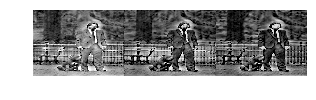

In [11]:
vis_act = [deprocess(out_img[...,:16]).transpose((2, 0, 1))]
for act in vis_act:
    display_in_row(act)